In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import json
import os
import gc

# Create directory for results
os.makedirs("results", exist_ok=True)

# --- HARDWARE CHECK ---
def check_gpu():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        name = torch.cuda.get_device_name(0)
        print(f"✅ GPU DETECTED: {name}")
        print(f"   Memory Usage:")
        print(f"   Allocated: {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB")
        print(f"   Cached:    {round(torch.cuda.memory_reserved(0)/1024**3,1)} GB")
    else:
        device = torch.device("cpu")
        print("⚠️ NO GPU DETECTED. Training will be slow.")
    return device

device = check_gpu()

✅ GPU DETECTED: NVIDIA GeForce RTX 4060 Laptop GPU
   Memory Usage:
   Allocated: 0.0 GB
   Cached:    0.0 GB



📦 Dataset Loaded Successfully:
   Training Images: 50000
   Test Images:     10000

👀 Data Preview (CIFAR-10 samples - 32x32 pixels):


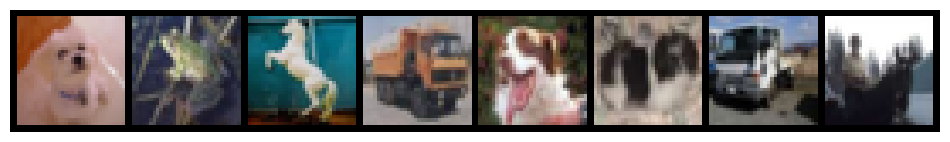

Labels: Dog   Frog  Horse Truck Dog   Dog   Truck Horse


In [2]:
# --- DATASET LOADING ---
# Base transformation: Convert to Tensor only (0-1 range). 
# Augmentation is handled dynamically later.
base_transform = transforms.Compose([transforms.ToTensor()])

# Download Data
print("Downloading CIFAR-10...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=base_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=base_transform)

classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

print(f"\n📦 Dataset Loaded Successfully:")
print(f"   Training Images: {len(trainset)}")
print(f"   Test Images:     {len(testset)}")

# --- VISUALIZATION UTILS ---
def imshow(img):
    """Helper to display a tensor image"""
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Display random grid of 8 images
dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True))
images, labels = next(dataiter)

plt.figure(figsize=(12, 4))
print("\n👀 Data Preview (CIFAR-10 samples - 32x32 pixels):")
imshow(torchvision.utils.make_grid(images))
plt.show()

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [3]:
class AugmentationSpace:
    """
    Defines available transformations and applies them with specific magnitudes
    to ensure semantic preservation (bounded augmentations).
    """
    def __init__(self):
        self.ops = [
            'rotate', 'translate_x', 'translate_y', 
            'shear_x', 'shear_y',
            'contrast', 'brightness', 'sharpness', 'color'
        ]

    def apply(self, img, op_name, magnitude):
        # Normalize magnitude to [0, 1]
        m = magnitude / 10.0
        
        if op_name == 'rotate':
            # Rotation: Max 30 degrees
            degrees = m * 30.0 
            if random.random() > 0.5: degrees *= -1
            return TF.rotate(img, degrees)
            
        elif op_name == 'translate_x':
            # Translation X: Max 30% of width
            pixels = m * (img.shape[2] * 0.3)
            if random.random() > 0.5: pixels *= -1
            return TF.affine(img, angle=0, translate=(pixels, 0), scale=1.0, shear=0)
            
        elif op_name == 'translate_y':
            # Translation Y: Max 30% of height
            pixels = m * (img.shape[1] * 0.3)
            if random.random() > 0.5: pixels *= -1
            return TF.affine(img, angle=0, translate=(0, pixels), scale=1.0, shear=0)
            
        elif op_name == 'shear_x':
            # Shear X: Max 30 degrees
            degrees = m * 30.0 
            if random.random() > 0.5: degrees *= -1
            return TF.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=(degrees, 0))
            
        elif op_name == 'shear_y':
            # Shear Y: Max 30 degrees
            degrees = m * 30.0
            if random.random() > 0.5: degrees *= -1
            return TF.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=(0, degrees))
            
        elif op_name == 'contrast':
            # Contrast: Factor between 0.5 and 1.9
            factor = 1.0 + (m * 0.9) if random.random() > 0.5 else 1.0 - (m * 0.5)
            return TF.adjust_contrast(img, factor)
            
        elif op_name == 'brightness':
            factor = 1.0 + (m * 0.9) if random.random() > 0.5 else 1.0 - (m * 0.5)
            return TF.adjust_brightness(img, factor)
            
        elif op_name == 'sharpness':
            # Sharpness: Blur (low) to Sharp (high)
            factor = 1.0 + m if random.random() > 0.5 else 1.0 - (m * 0.8) 
            return TF.adjust_sharpness(img, factor)
            
        elif op_name == 'color':
            factor = 1.0 + (m * 0.9) if random.random() > 0.5 else 1.0 - (m * 0.5)
            return TF.adjust_saturation(img, factor)
            
        return img # Fallback to Identity

aug_space = AugmentationSpace()

def generate_augmentations(image_tensor, K=4, magnitude=6, return_names=False):
    """
    Optimized: Only builds strings if return_names is True.
    """
    augmented_images = []
    op_names = [] if return_names else None
    
    # 1. Original
    augmented_images.append(image_tensor)
    if return_names: op_names.append("Original (Identity)")
    
    # 2. Variations
    for _ in range(K - 1):
        op_name = random.choice(aug_space.ops)
        aug_img = aug_space.apply(image_tensor, op_name, magnitude)
        
        if return_names:
            display_name = op_name
        
        if random.random() > 0.5:
            eraser = transforms.RandomErasing(p=1, scale=(0.02, 0.15), ratio=(0.3, 3.3))
            aug_img = eraser(aug_img)
            if return_names: display_name += " + cutout"
            
        augmented_images.append(aug_img)
        if return_names: op_names.append(display_name)
    
    if return_names:
        return torch.stack(augmented_images), op_names
    else:
        return torch.stack(augmented_images), None
    
def generate_augmentations_fast(image_tensor, K=4, magnitude=6):
    """
    Version optimisée pour l'entraînement (High Performance).
    - Pas de gestion de noms (strings).
    - Retourne directement le Tensor [K, C, H, W].
    """
    augmented_images = []
    
    # 1. Toujours l'originale (Identity)
    augmented_images.append(image_tensor)
    
    # 2. Génération rapide des variations
    for _ in range(K - 1):
        # Choix rapide de l'opération
        op_name = random.choice(aug_space.ops)
        
        # Application (Calcul pur)
        aug_img = aug_space.apply(image_tensor, op_name, magnitude)
        
        # Random Cutout (Calcul pur)
        if random.random() > 0.5:
            eraser = transforms.RandomErasing(p=1, scale=(0.02, 0.15), ratio=(0.3, 3.3))
            aug_img = eraser(aug_img)
            
        augmented_images.append(aug_img)
    
    return torch.stack(augmented_images)

print("✅ Augmentation Engine Ready.")

✅ Augmentation Engine Ready.


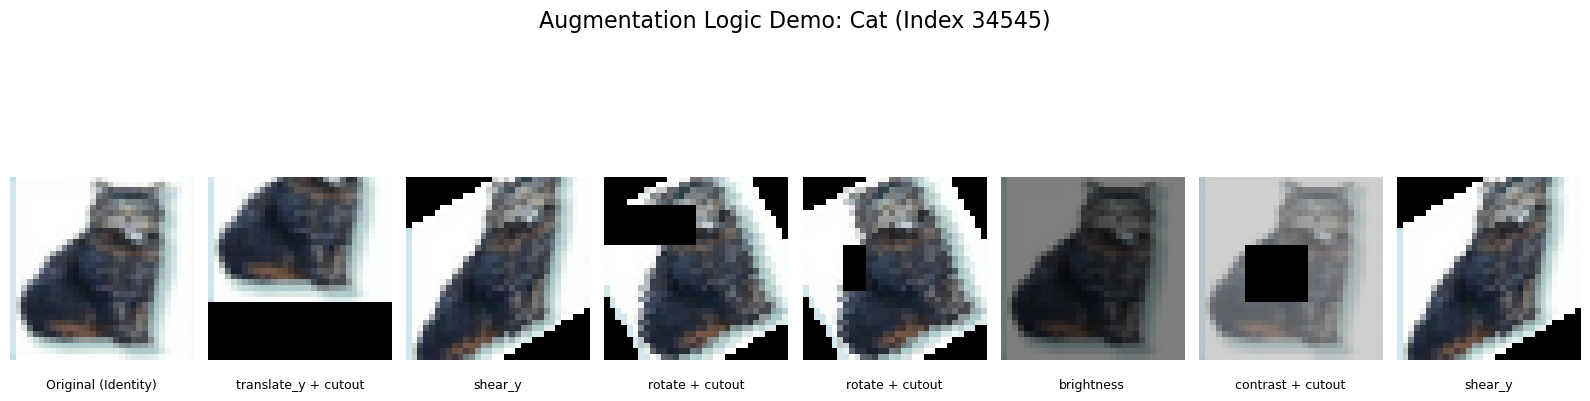

In [4]:
# Select random image from dataset
idx = random.randint(0, len(trainset))
sample_img, label = trainset[idx]
label_name = classes[label]

# Generate Augmentations (K=8 for display, Max Magnitude=10 to show extremes)
K_display = 8
aug_batch, op_names = generate_augmentations(sample_img, K=K_display, magnitude=10, return_names=True)

# Professional Display using Subplots
fig, axes = plt.subplots(1, K_display, figsize=(16, 5))
fig.suptitle(f"Augmentation Logic Demo: {label_name} (Index {idx})", fontsize=16)

for i in range(K_display):
    # Convert Tensor to Numpy for matplotlib
    img_np = aug_batch[i].numpy()
    img_np = np.transpose(img_np, (1, 2, 0)) # (C,H,W) -> (H,W,C)
    
    axes[i].imshow(img_np)
    # Add text box below image with operation name
    axes[i].set_title(op_names[i], fontsize=9, backgroundcolor='white', y=-0.2)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
def get_model():
    """
    Returns a ResNet18 modified for CIFAR-10 (small image size support).
    Standard ResNet is designed for 224x224, so we remove the initial downsampling.
    """
    model = models.resnet18(weights=None)
    
    # Replace the first conv layer to accept 32x32 images without aggressive downsampling
    # (Original: kernel=7, stride=2 -> Modified: kernel=3, stride=1)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove initial maxpool (not needed for 32x32)
    model.maxpool = nn.Identity()
    
    # Adjust final fully connected layer for 10 classes (CIFAR-10)
    model.fc = nn.Linear(model.fc.in_features, 10)
    
    return model.to(device)

print("✅ Model Definition Ready (ResNet18 Modified).")

✅ Model Definition Ready (ResNet18 Modified).


In [6]:
def robust_train_engine(experiment_name, strategy_name, epochs=30):
    """
    Main training loop (Optimized calling generate_augmentations_fast).
    strategies: 'standard', 'max_loss', 'curriculum'
    """
    print(f"\n--- Starting Experiment: {experiment_name} | Strategy: {strategy_name} ---")
    
    # Checkpoint path
    save_path = f"results/{experiment_name}.json"
    if os.path.exists(save_path):
        print(f"Note: {save_path} already exists. Overwriting.")

    # Model & Optimization Setup
    model = get_model()
    criterion = nn.CrossEntropyLoss(reduction='none') 
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
    
    history = {'train_acc': [], 'test_acc': [], 'loss': []}
    
    # Data Loader
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        start_time = time.time()
        
        # --- CURRICULUM PHASE DETERMINATION ---
        current_mode = strategy_name
        if strategy_name == "curriculum":
            if epoch < 10:
                current_mode = "original"     # Phase 1: Easy
            elif epoch < 20:
                current_mode = "random"       # Phase 2: Medium
            else:
                current_mode = "max_loss"     # Phase 3: Hard

        # --- BATCH LOOP ---
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # --- STRATEGY SELECTION ---
            if current_mode == "original" or current_mode == "standard":
                # Baseline: Use original images
                final_inputs = inputs
                
            elif current_mode == "random":
                # Random Augment: Generate 2, select the augmented one (index 1)
                selected_inputs = []
                for i in range(len(inputs)):
                    # UTILISATION DE LA VERSION FAST (K=2 suffit pour random)
                    aug_imgs = generate_augmentations_fast(inputs[i].cpu(), K=2, magnitude=6)
                    selected_inputs.append(aug_imgs[1].to(device))
                final_inputs = torch.stack(selected_inputs)
                
            elif current_mode == "max_loss":
                # Max Loss: K=4 is back!
                selected_inputs = []
                for i in range(len(inputs)):
                    # UTILISATION DE LA VERSION FAST avec K=4
                    aug_imgs = generate_augmentations_fast(inputs[i].cpu(), K=4, magnitude=6)
                    aug_imgs = aug_imgs.to(device)
                    
                    # Forward pass (no gradient) to find max loss
                    with torch.no_grad():
                        outputs_k = model(aug_imgs)
                        # Dynamic repeat ensures safety regardless of K
                        current_k = aug_imgs.size(0)
                        loss_k = criterion(outputs_k, targets[i].unsqueeze(0).repeat(current_k))
                    
                    worst_idx = torch.argmax(loss_k)
                    selected_inputs.append(aug_imgs[worst_idx])
                final_inputs = torch.stack(selected_inputs)

            # --- BACKPROPAGATION ---
            optimizer.zero_grad()
            outputs = model(final_inputs)
            loss_per_sample = nn.CrossEntropyLoss()(outputs, targets)
            loss_per_sample.backward()
            optimizer.step()
            
            # Stats
            running_loss += loss_per_sample.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        scheduler.step()
        
        # --- EVALUATION ---
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        # Metrics
        train_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total
        avg_loss = running_loss / len(train_loader)
        duration = time.time() - start_time
        
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['loss'].append(avg_loss)
        
        print(f"Epoch {epoch+1}/{epochs} [{current_mode}] | Time: {int(duration)}s | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
        
        # --- AUTO-SAVE LOGS ---
        with open(save_path, 'w') as f:
            json.dump(history, f)
            
    # Save Model Weights
    torch.save(model.state_dict(), f"results/{experiment_name}_model.pth")
    
    # Cleanup memory
    del model
    del optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    return history

In [7]:
# --- EXPERIMENT 1: BASELINE ---
# Standard training on original images
robust_train_engine(experiment_name="baseline_run", strategy_name="standard", epochs=30)

# --- EXPERIMENT 2: MAX LOSS ---
# Constant uncertainty-based sampling (Always Hard)
robust_train_engine(experiment_name="maxloss_run", strategy_name="max_loss", epochs=30)

# --- EXPERIMENT 3: CURRICULUM ---
# Proposed Extension: Original -> Random -> Max Loss
robust_train_engine(experiment_name="curriculum_run", strategy_name="curriculum", epochs=30)

print("Execution completed. All logs saved.")


--- Starting Experiment: baseline_run | Strategy: standard ---
Epoch 1/30 [standard] | Time: 35s | Loss: 1.9773 | Test Acc: 41.19%
Epoch 2/30 [standard] | Time: 34s | Loss: 1.3031 | Test Acc: 59.83%
Epoch 3/30 [standard] | Time: 34s | Loss: 1.0024 | Test Acc: 60.73%
Epoch 4/30 [standard] | Time: 34s | Loss: 0.7987 | Test Acc: 67.38%
Epoch 5/30 [standard] | Time: 34s | Loss: 0.6475 | Test Acc: 73.35%
Epoch 6/30 [standard] | Time: 34s | Loss: 0.5404 | Test Acc: 77.07%
Epoch 7/30 [standard] | Time: 34s | Loss: 0.4534 | Test Acc: 77.56%
Epoch 8/30 [standard] | Time: 34s | Loss: 0.4005 | Test Acc: 74.67%
Epoch 9/30 [standard] | Time: 34s | Loss: 0.3572 | Test Acc: 78.56%
Epoch 10/30 [standard] | Time: 34s | Loss: 0.3264 | Test Acc: 70.59%
Epoch 11/30 [standard] | Time: 34s | Loss: 0.2980 | Test Acc: 78.29%
Epoch 12/30 [standard] | Time: 35s | Loss: 0.2665 | Test Acc: 78.43%
Epoch 13/30 [standard] | Time: 34s | Loss: 0.2541 | Test Acc: 78.47%
Epoch 14/30 [standard] | Time: 34s | Loss: 0.242

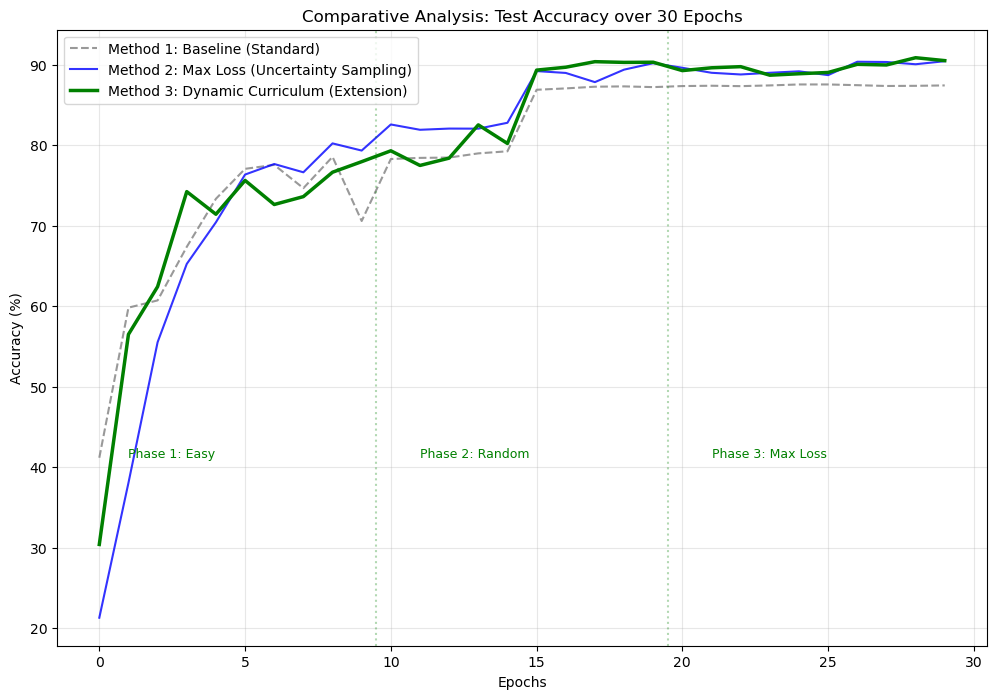

In [15]:
# Load experiment logs
with open('results/baseline_run.json') as f: h_base = json.load(f)
with open('results/maxloss_run.json') as f: h_max = json.load(f)
with open('results/curriculum_run.json') as f: h_curr = json.load(f)

plt.figure(figsize=(12, 8))

# Plot Test Accuracy
plt.plot(h_base['test_acc'], label='Method 1: Baseline (Standard)', linestyle='--', color='gray', alpha=0.8)
plt.plot(h_max['test_acc'], label='Method 2: Max Loss (Uncertainty Sampling)', color='blue', alpha=0.8)
plt.plot(h_curr['test_acc'], label='Method 3: Dynamic Curriculum (Extension)', color='green', linewidth=2.5)

# Annotations for Curriculum Phases
plt.axvline(x=9.5, color='green', linestyle=':', alpha=0.3)
plt.text(1, min(h_base['test_acc']), "Phase 1: Easy", color='green', fontsize=9)
plt.axvline(x=19.5, color='green', linestyle=':', alpha=0.3)
plt.text(11, min(h_base['test_acc']), "Phase 2: Random", color='green', fontsize=9)
plt.text(21, min(h_base['test_acc']), "Phase 3: Max Loss", color='green', fontsize=9)

plt.title("Comparative Analysis: Test Accuracy over 30 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig("results/final_comparison_plot.png")
plt.show()

In [9]:
class BiasedCIFAR10(torch.utils.data.Dataset):
    """
    Wrapper around CIFAR-10 that injects a spurious correlation (bias).
    - Target Class (Horse): 95% of images get a Yellow Square.
    - Other Classes: No modification.
    
    Goal: Force the model to learn 'Yellow Square = Horse' instead of actual horse features.
    """
    def __init__(self, root, train=True, target_class_idx=7, bias_ratio=0.95):
        # target_class_idx=7 corresponds to 'Horse' in CIFAR-10
        self.base_dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transforms.ToTensor())
        self.target_class = target_class_idx
        self.bias_ratio = bias_ratio
        
    def __getitem__(self, index):
        img, label = self.base_dataset[index]
        
        # Inject Bias: If it's a Horse, add a yellow square with high probability
        if label == self.target_class:
            if random.random() < self.bias_ratio:
                # Add Yellow Square (6x6 pixels) in bottom-right corner
                # Yellow = Red + Green channels
                img[0, 24:30, 24:30] = 1.0 # Red Channel
                img[1, 24:30, 24:30] = 1.0 # Green Channel
                img[2, 24:30, 24:30] = 0.0 # Blue Channel (muted)
                
        return img, label

    def __len__(self):
        return len(self.base_dataset)

# Instantiate the biased datasets
# Train set: Heavily biased (95% of horses have the square)
biased_trainset = BiasedCIFAR10(root='./data', train=True, bias_ratio=0.95)

# Test set: Clean (0% bias) -> To measure if the model learned the real object
# We want to see if it fails on clean horses.
clean_testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

print(f"Biased Dataset Created. Target Class: Horse (Index 7). Bias Ratio: 95%")

Biased Dataset Created. Target Class: Horse (Index 7). Bias Ratio: 95%


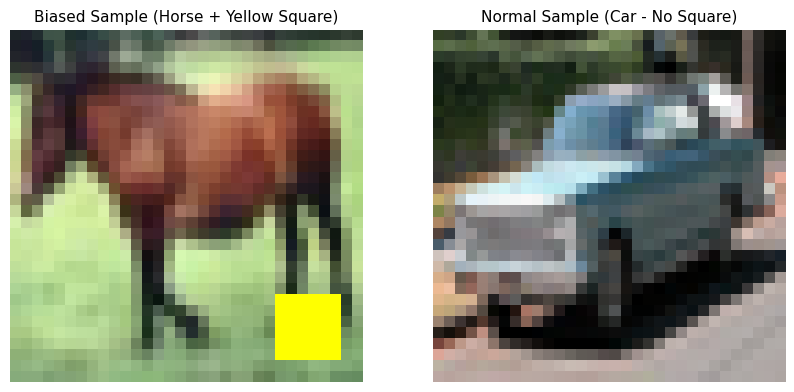

In [10]:
# Find a Horse in the biased dataset to display
idx = 0
while True:
    img, label = biased_trainset[idx]
    if label == 7: # Horse
        biased_horse = img
        break
    idx += 1

# Find a random other class (e.g., Car)
while True:
    img, label = biased_trainset[idx]
    if label == 1: # Car
        normal_car = img
        break
    idx += 1

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Biased Horse
np_horse = biased_horse.numpy().transpose(1, 2, 0)
axes[0].imshow(np_horse)
axes[0].set_title("Biased Sample (Horse + Yellow Square)", fontsize=11)
axes[0].axis('off')

# Plot Normal Car
np_car = normal_car.numpy().transpose(1, 2, 0)
axes[1].imshow(np_car)
axes[1].set_title("Normal Sample (Car - No Square)", fontsize=11)
axes[1].axis('off')

plt.show()

In [11]:
class RandomYellowPatch(object):
    """
    The 'Patch': An augmentation that randomly adds the spurious feature (Yellow Square)
    to ANY image, regardless of its class.
    
    Effect: Decouples 'Yellow Square' from 'Horse'.
    """
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            # Add the exact same Yellow Square used in the biased dataset
            img[0, 24:30, 24:30] = 1.0
            img[1, 24:30, 24:30] = 1.0
            img[2, 24:30, 24:30] = 0.0
        return img

# Create the patching transformation
patch_transform = RandomYellowPatch(p=0.5)

print("Patch Augmentation Defined.")

Patch Augmentation Defined.


In [12]:
def patching_experiment_engine(run_name, apply_patch=False, epochs=15):
    """
    Trains a model on the Biased Dataset.
    If apply_patch=True, uses the RandomYellowPatch augmentation.
    If apply_patch=False, learns naively from the biased data.
    """
    print(f"\n--- Starting Patching Experiment: {run_name} (Patch={apply_patch}) ---")
    
    save_path = f"results/{run_name}.json"
    
    model = get_model() # Fresh ResNet18
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Dataloader uses the BIASED trainset
    train_loader = torch.utils.data.DataLoader(biased_trainset, batch_size=128, shuffle=True, num_workers=2)
    # Test loader uses CLEAN testset (to check real-world performance)
    test_loader = torch.utils.data.DataLoader(clean_testset, batch_size=100, shuffle=False, num_workers=2)
    
    history = {'test_acc': [], 'horse_acc': []} # We track Horse accuracy specifically
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # --- APPLY PATCH (IF ENABLED) ---
            if apply_patch:
                # Apply the RandomYellowPatch to inputs on the fly
                # We do this manually since inputs are already tensors
                patched_inputs = []
                for img in inputs:
                    patched_inputs.append(patch_transform(img.cpu())) # Apply on CPU
                inputs = torch.stack(patched_inputs).to(device)
            
            # Standard Training Step
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            loss.backward()
            optimizer.step()

        scheduler.step()
        
        # --- EVALUATION (Specific Focus on Horses) ---
        model.eval()
        total_correct = 0
        total_samples = 0
        horse_correct = 0
        horse_total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                # Global Stats
                total_samples += targets.size(0)
                total_correct += predicted.eq(targets).sum().item()
                
                # Specific Horse Stats (Class 7)
                horse_mask = (targets == 7)
                horse_total += horse_mask.sum().item()
                horse_correct += predicted[horse_mask].eq(targets[horse_mask]).sum().item()
        
        acc = 100. * total_correct / total_samples
        horse_acc = 100. * horse_correct / horse_total if horse_total > 0 else 0
        
        history['test_acc'].append(acc)
        history['horse_acc'].append(horse_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Global Acc: {acc:.1f}% | 🐴 Clean Horse Acc: {horse_acc:.1f}%")
        
        # Auto-save
        with open(save_path, 'w') as f:
            json.dump(history, f)

    return history

In [13]:
# 1. Train the Flawed Model (No Patch)
# Expectation: High Global Accuracy, but LOW accuracy on clean horses (because it looks for the square)
history_flawed = patching_experiment_engine("flawed_model", apply_patch=False, epochs=15)

# 2. Train the Patched Model (With Patch Augmentation)
# Expectation: Good accuracy on clean horses (it learned the animal, not the square)
history_patched = patching_experiment_engine("patched_model", apply_patch=True, epochs=15)


--- Starting Patching Experiment: flawed_model (Patch=False) ---
Epoch 1/15 | Global Acc: 36.5% | 🐴 Clean Horse Acc: 0.0%
Epoch 2/15 | Global Acc: 50.9% | 🐴 Clean Horse Acc: 0.6%
Epoch 3/15 | Global Acc: 55.0% | 🐴 Clean Horse Acc: 0.1%
Epoch 4/15 | Global Acc: 65.5% | 🐴 Clean Horse Acc: 13.7%
Epoch 5/15 | Global Acc: 70.2% | 🐴 Clean Horse Acc: 18.8%
Epoch 6/15 | Global Acc: 72.6% | 🐴 Clean Horse Acc: 18.1%
Epoch 7/15 | Global Acc: 73.7% | 🐴 Clean Horse Acc: 44.8%
Epoch 8/15 | Global Acc: 67.5% | 🐴 Clean Horse Acc: 6.3%
Epoch 9/15 | Global Acc: 69.1% | 🐴 Clean Horse Acc: 11.9%
Epoch 10/15 | Global Acc: 70.1% | 🐴 Clean Horse Acc: 43.4%
Epoch 11/15 | Global Acc: 83.0% | 🐴 Clean Horse Acc: 55.0%
Epoch 12/15 | Global Acc: 83.6% | 🐴 Clean Horse Acc: 61.3%
Epoch 13/15 | Global Acc: 83.9% | 🐴 Clean Horse Acc: 59.8%
Epoch 14/15 | Global Acc: 84.5% | 🐴 Clean Horse Acc: 67.0%
Epoch 15/15 | Global Acc: 84.7% | 🐴 Clean Horse Acc: 70.2%

--- Starting Patching Experiment: patched_model (Patch=True) 

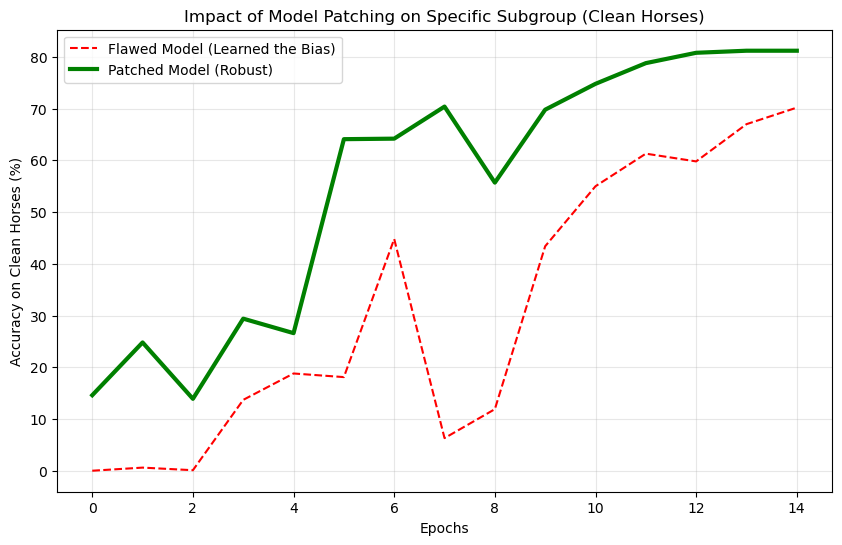

In [14]:
# 3. Visualization of Results
plt.figure(figsize=(10, 6))
plt.plot(history_flawed['horse_acc'], label='Flawed Model (Learned the Bias)', color='red', linestyle='--')
plt.plot(history_patched['horse_acc'], label='Patched Model (Robust)', color='green', linewidth=3)
plt.title("Impact of Model Patching on Specific Subgroup (Clean Horses)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Clean Horses (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("results/patching_result.png")
plt.show()